This is a notebook to analyse neural responses to sound presentations. 
Ephys data is recorded using openEphys
Sound presentation is done with bpod and matlab
During sound presentation a ttl is sent to openEphys from bpod itself

In [1]:
# Add modules to the path
import sys
sys.path.insert(0, '/mnt/c/Users/herny/OneDrive/Documents/GitHub/')

In [2]:
# Import helpers
from BehaviouralAnalysis.utils import data_reader
from BehaviouralAnalysis.utils.plot_utils import axvlines
import pyopenephys
import matplotlib.pylab as plt
from utils.custom_functions import getFirstPulses
import numpy as np
from scipy.signal import argrelextrema
import time
import pickle

<br><br>Behavioural data

In [3]:
# Behavioral data
BehavPath = '/mnt/c/Users/herny/Desktop/SWC/Data/Behavioural_Data/Bpod_data/'
BehavFilePath = 'Green/Sound_Presentation/Session Data/Green_Sound_Presentation_20190305_101010.mat'
Behav_Data_Dict = data_reader.Bpod_Sound_Presentation(BehavPath + BehavFilePath)


In [4]:
stimulus_order = Behav_Data_Dict['Stimulus']

<br><br>Ephys data

In [5]:
OEpath = '/mnt/c/Users/herny/Desktop/SWC/Data/Ephys_data/SoundResponses/'
Experiment = 'Red_2019-03-05_19-01-16_SoundResponses'
OEfile = pyopenephys.File(OEpath + Experiment)

Loading Open-Ephys: reading settings.xml...
Decoding data from  binary  format


In [6]:
recording = OEfile.experiments[0].recordings[0]
print('Duration: ', recording.duration)
print('Sampling Rate: ', recording.sample_rate)

.dat:  continuous.dat
Estimated samples:  37748224  Numchan:  35
Duration:  1258.2741 1/Hz
Sampling Rate:  30000.0 Hz


In [7]:
BpodTTLs = recording.events[0].times
AnalogSignals = recording.analog_signals[0]

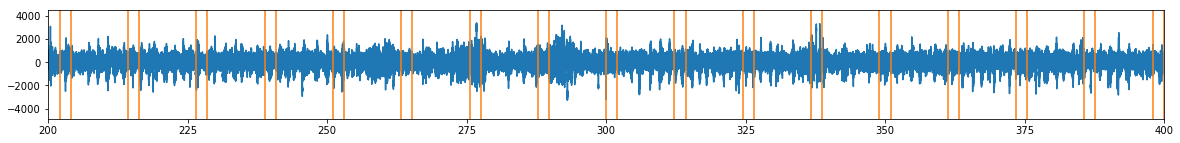

In [8]:
# plot analog signal of channel 4
fig_an, ax_an = plt.subplots(figsize=(20, 2))
ax_an.plot(AnalogSignals.times, AnalogSignals.signal[3])
axvlines(BpodTTLs)
plt.xlim(200, 400)
plt.show()


In [9]:
#Detect first events (separated by at least 5 seconds)
soundPresentationTimes  = getFirstPulses(BpodTTLs, 5)

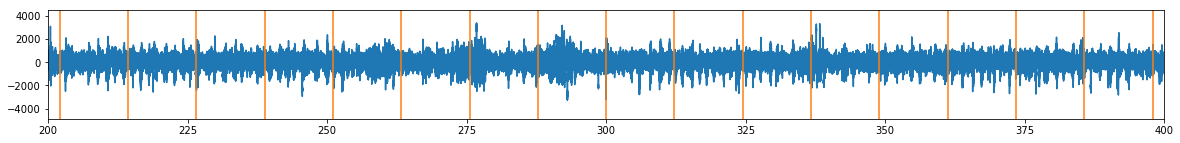

In [10]:
# plot first pulses
fig_an, ax_an = plt.subplots(figsize=(20, 2))
ax_an.plot(AnalogSignals.times, AnalogSignals.signal[3])
axvlines(soundPresentationTimes)
plt.xlim(200, 400)
plt.show()

<br><br>Check that datasets match

In [11]:
if len(soundPresentationTimes) == len(stimulus_order):
    print('Datasets match')
else:
    print('Datasets do not match!!!')
    

Datasets match


<br><br>Get spikes from the ephys data

In [12]:
# Calculate the median of all channels
MedianSignal = np.median(AnalogSignals.signal[range(32)], axis = 0)

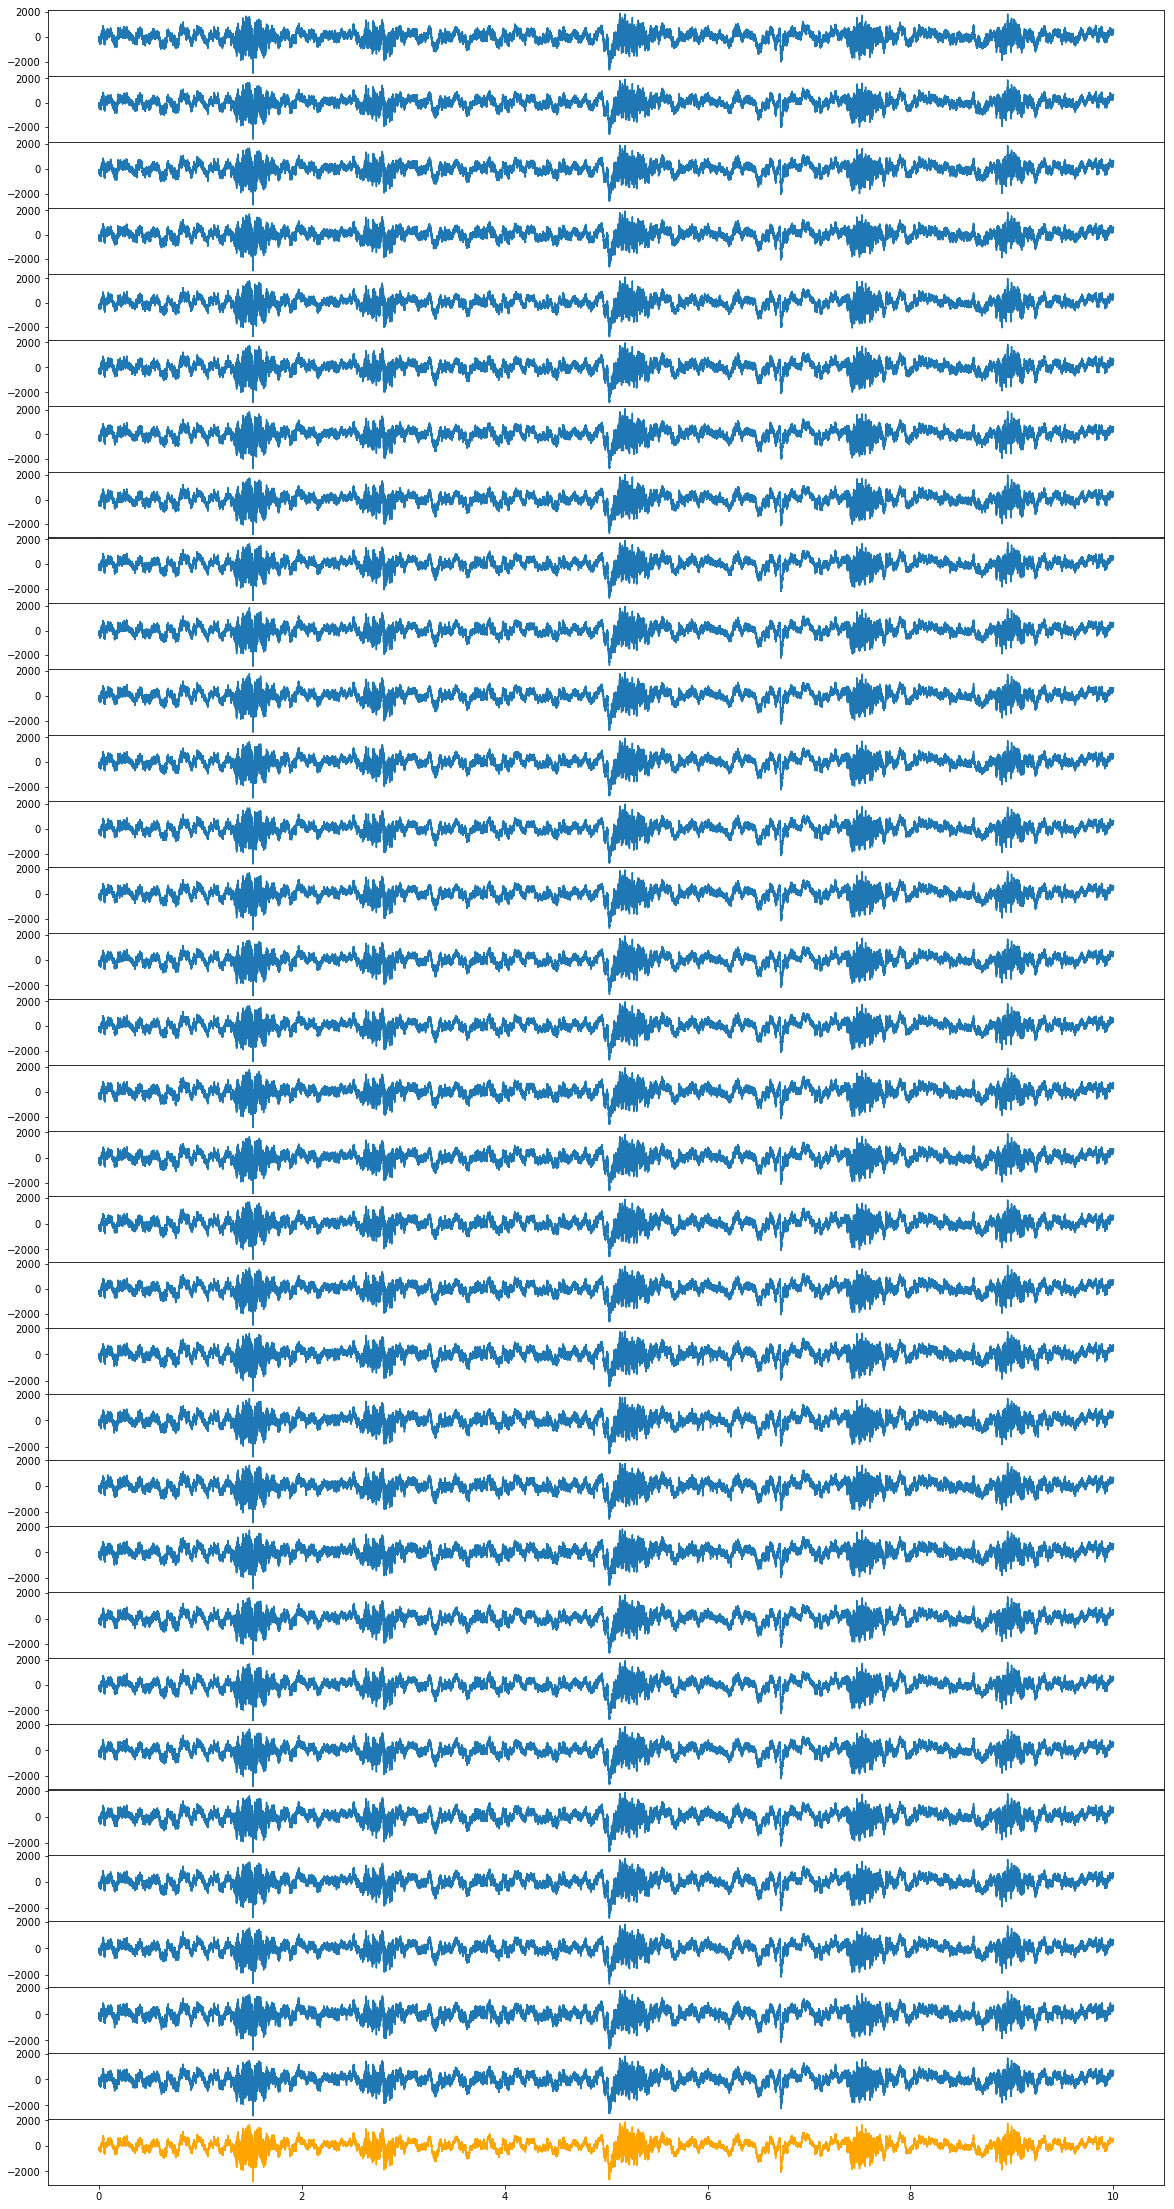

In [13]:
# Plot all channels and the median
PlotX = range(0,300000)

fig, axs = plt.subplots(33, 1, figsize=(20, 40) , facecolor='w', edgecolor='k', sharex=True)
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()

for i in range(32):
    axs[i].plot(AnalogSignals.times[PlotX], AnalogSignals.signal[i][PlotX])
    #axs[i].text(.5,.9,"Channel Idx "+str(i), horizontalalignment='center', transform=axs[i].transAxes)
    
    #print(i)
axs[i+1].plot(AnalogSignals.times[PlotX], MedianSignal[PlotX], color = 'orange')
plt.show()

In [14]:
# Subtract the median from all channels
RefSignals = AnalogSignals.signal - MedianSignal

In [15]:
# Compute the standard deviation of every channel
RefSignalsSD = np.std(RefSignals, axis = 1)

In [25]:
# Theshold cut-off
SD_cutoff = 4.5

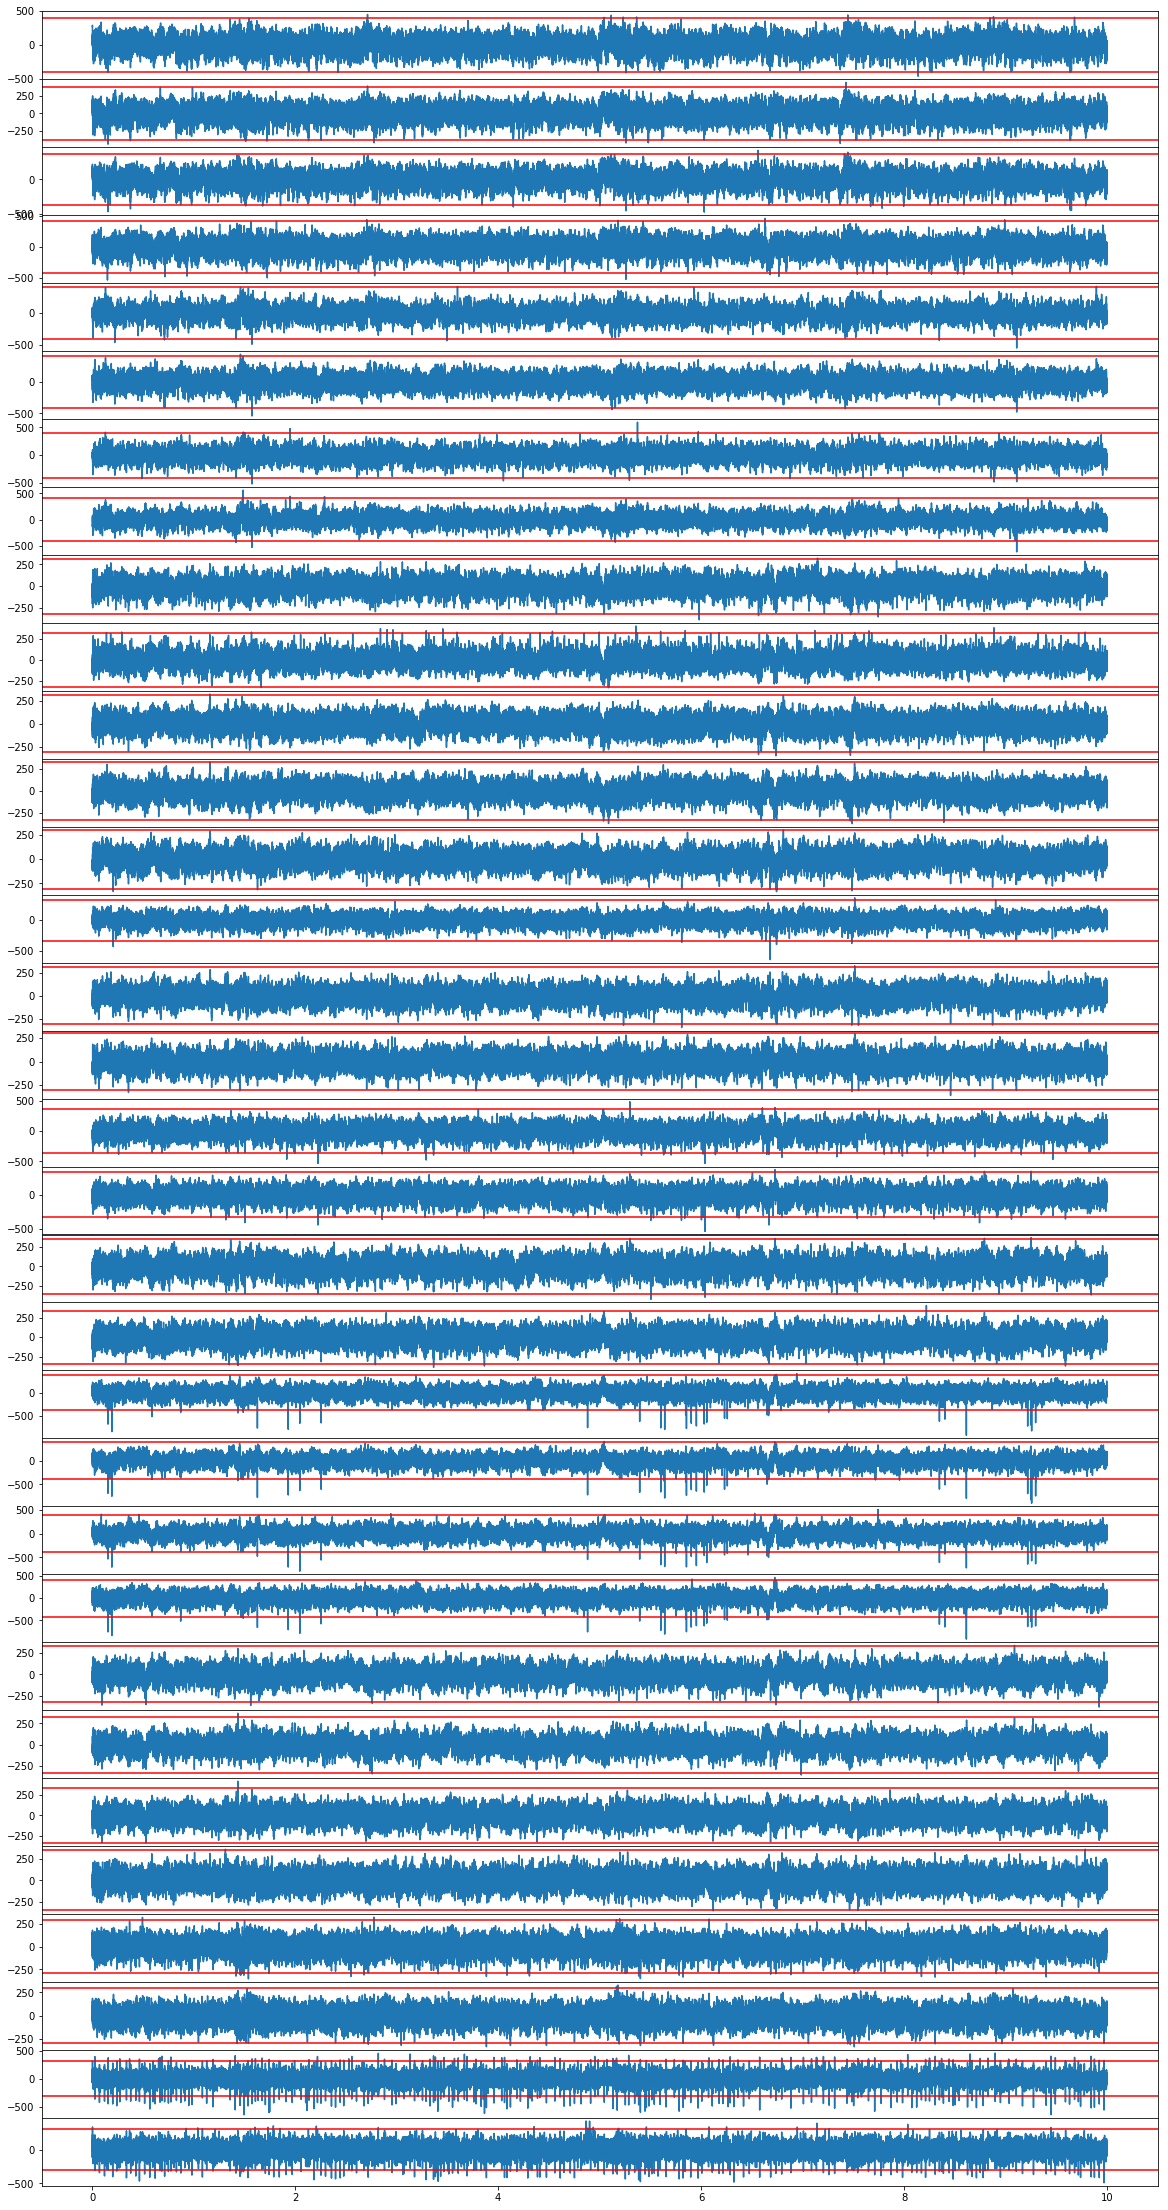

In [26]:
# Plot
PlotX = range(0,300000)
fig, axs = plt.subplots(32, 1, figsize=(20, 40) , facecolor='w', edgecolor='k', sharex=True)
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()

for i in range(32):
    axs[i].plot(AnalogSignals.times[PlotX], RefSignals[i][PlotX])
    #axs[i].text(.5,.9,"Channel Idx "+str(i), horizontalalignment='center', transform=axs[i].transAxes)
    # plot SD
    axs[i].axhline(SD_cutoff*RefSignalsSD[i], color = 'red')
    axs[i].axhline(-SD_cutoff*RefSignalsSD[i], color = 'red')
    
    #print(i)
plt.show()

In [27]:
# Detect threshold crossings
start = time.time()
SignalsSpikes = [None] * 32

for Channel in range(32):
    # Get the time points above/below the cutoff
    #SigMaxIdx = argrelextrema(Channel, np.greater)
    Crossings = AnalogSignals.times[abs(RefSignals[Channel])>SD_cutoff*RefSignalsSD[Channel]]

    # Get the first events in less than 2ms
    if len(Crossings)>0:
        SignalsSpikes[Channel] = getFirstPulses(Crossings, 0.002)
    
    print(Channel)
    
print(start - time.time())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
-145.84220170974731


In [28]:
# Save the data
# Saving the objects:
with open(OEpath + Experiment + '_preProcessed_cutoff_'+ str(SD_cutoff) + '.pkl', 'wb') as f:
    pickle.dump([MedianSignal, RefSignalsSD, SignalsSpikes], f)

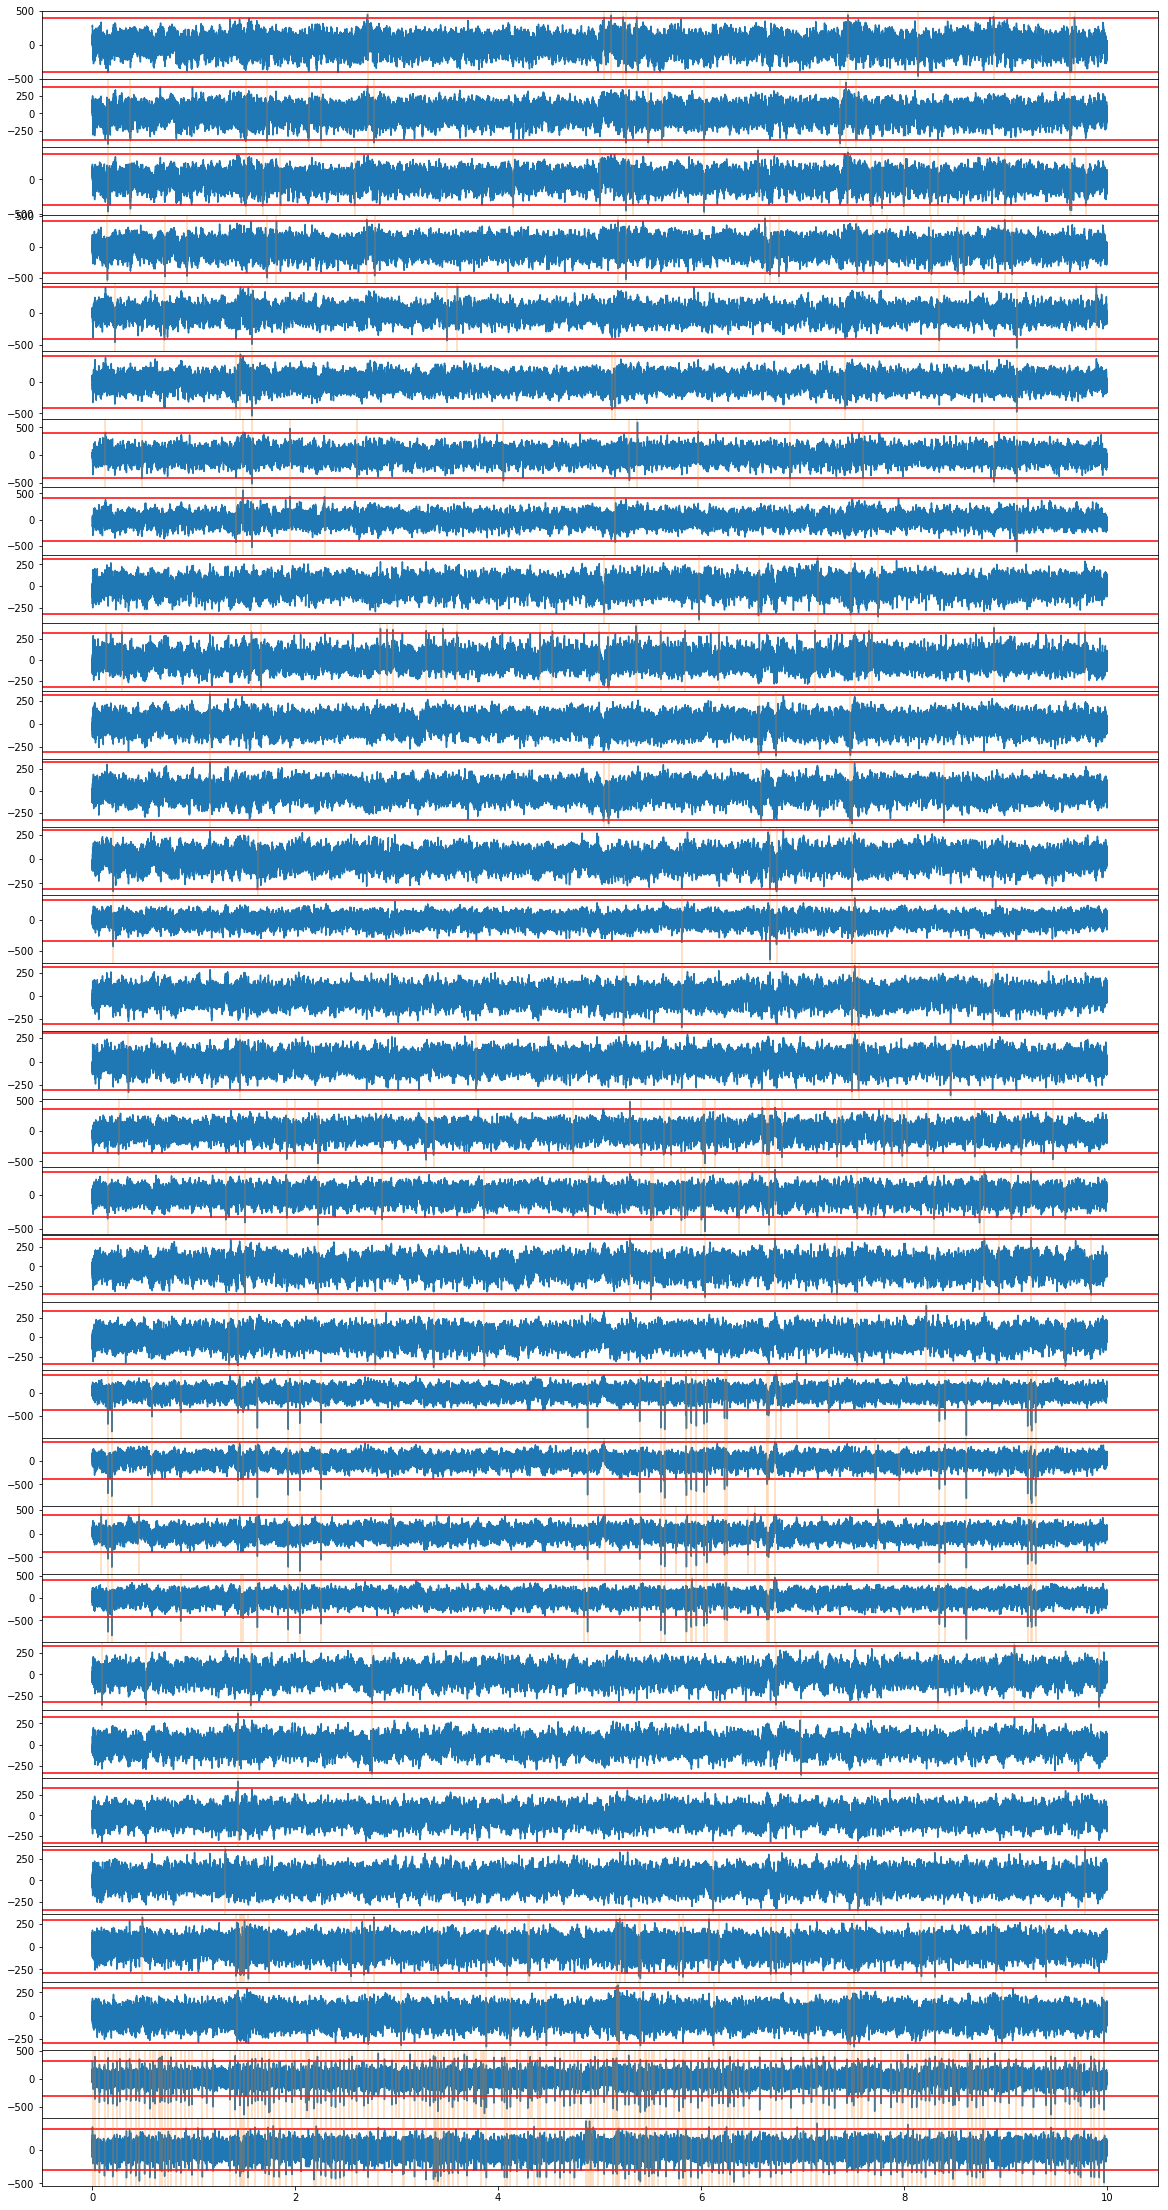

In [29]:
# Plot
PlotX = range(0,300000)
fig, axs = plt.subplots(32, 1, figsize=(20, 40) , facecolor='w', edgecolor='k', sharex=True)
fig.subplots_adjust(hspace = .001, wspace=.001)
axs = axs.ravel()

for i in range(32):
    axs[i].plot(AnalogSignals.times[PlotX], RefSignals[i][PlotX])
    #axs[i].text(.5,.9,"Channel Idx "+str(i), horizontalalignment='center', transform=axs[i].transAxes)
    # plot SD
    axs[i].axhline(SD_cutoff*RefSignalsSD[i], color = 'red')
    axs[i].axhline(-SD_cutoff*RefSignalsSD[i], color = 'red')
    axvlines(SignalsSpikes[i][(SignalsSpikes[i]>=AnalogSignals.times[PlotX][0]) & (SignalsSpikes[i]<=AnalogSignals.times[PlotX][-1])], alpha=0.3, ax = axs[i])
    #print(i)
plt.show()

In [ ]:
# Getting back the objects:
with open(OEpath + Experiment + '_preProcessed_cutoff_'+ str(SD_cutoff) + '.pkl', 'wb') as f:
    MedianSignal, RefSignalsSD, SignalsSpikes = pickle.load(f)

<br><br>Create tuning curves

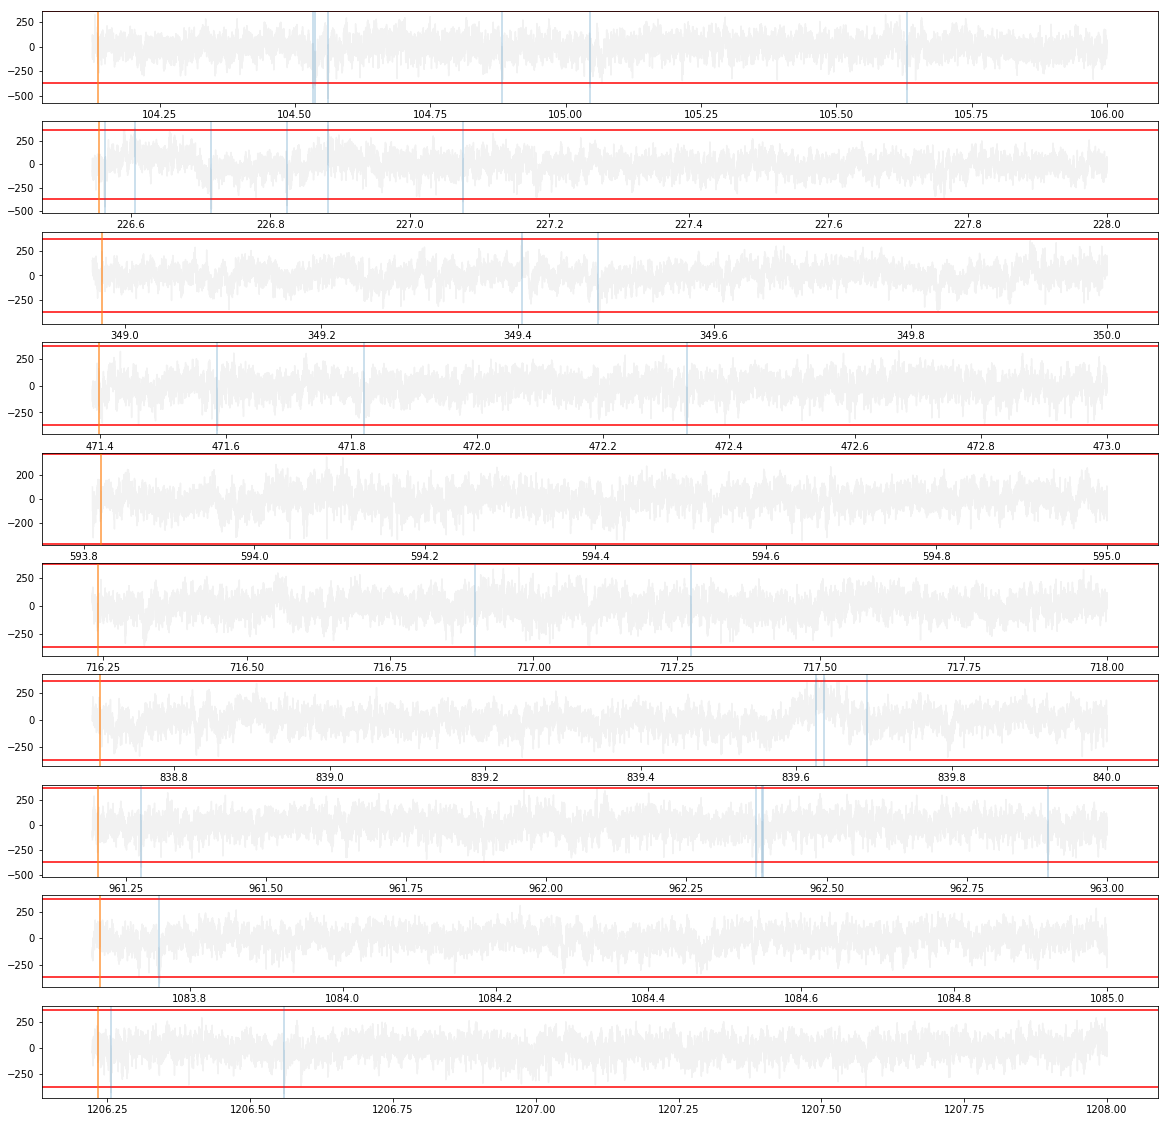

In [30]:
# plot a channel after the presentation of a sound
SecAfterSound = 2
SoundID = 9
Channel = 2
nSounds = 10


SoundTimes = soundPresentationTimes[stimulus_order==SoundID][0:nSounds]


fig, axs = plt.subplots(nSounds, 1, figsize=(20, 2*nSounds) , facecolor='w', edgecolor='k', sharex=False)
fig.subplots_adjust(hspace = 0.2, wspace=.001)
#axs = axs.ravel()

for i in range(nSounds):
    PlotX = range(int(30000*(SoundTimes[i].item()-0.01)), 30000*(int(SoundTimes[i].item()+SecAfterSound)))
    axs[i].plot(AnalogSignals.times[PlotX], RefSignals[Channel][PlotX], alpha = 0.1, color = 'grey')
    axs[i].axhline(SD_cutoff*RefSignalsSD[Channel], color = 'red')
    axs[i].axhline(-SD_cutoff*RefSignalsSD[Channel], color = 'red')
    axvlines(SignalsSpikes[Channel][(SignalsSpikes[Channel]>=AnalogSignals.times[PlotX][0]) & (SignalsSpikes[Channel]<=AnalogSignals.times[PlotX][-1])], alpha=0.3, ax = axs[i])
    axvlines(SoundTimes[(SoundTimes>=AnalogSignals.times[PlotX][0]) & (SoundTimes<=AnalogSignals.times[PlotX][-1])], alpha=0.8, ax = axs[i])
    #print(i)
plt.show()

In [ ]:
# Calculate the spike times per sound ID and per channel

# Create a structure to hold the spikes: SpikeCount[Channel][SoundID][nPresentation] -> list of spike times
SecAfterSound = 2
SpikeCount = [None] * 32
repOrSounds = len(stimulus_order)/len(set(stimulus_order))
Arr_unique, Arr_counts = np.unique(stimulus_order, return_counts=True)

for Channel in range(len(SpikeCount)):
    SoundIDcounts = [None] * len(set(stimulus_order))
    for SoundID in set(stimulus_order):
        SoundIDidx = int(np.where(Arr_unique==SoundID)[0])
        Counts = [None] * Arr_counts[SoundIDidx]
        for i in range(len(Counts)):
            SoundTime = soundPresentationTimes[stimulus_order==SoundID][i]
            calcWindow = range(int(30000*(SoundTime.item())), 30000*(int(SoundTime.item()+SecAfterSound)))
            Counts[i] = SignalsSpikes[Channel][(SignalsSpikes[Channel]>=AnalogSignals.times[calcWindow][0]) & (SignalsSpikes[Channel]<=AnalogSignals.times[calcWindow][-1])]
            
        SoundIDcounts[SoundIDidx] = Counts
    SpikeCount[Channel] = SoundIDcounts
            

In [ ]:
# use 2 seconds before the presentation of each sound to calculate the spikes during silent time


In [ ]:
FiringRate = [None] * len(SpikeCount[Channel][SoundIDidx])
for i in range(len(FiringRate)):
    FiringRate[i] = sum(len(x) for x in SpikeCount[Channel][i])

In [ ]:
fig, axs = plt.subplots(32, 1, figsize=(20, 50) , facecolor='w', edgecolor='k', sharex=True)
fig.subplots_adjust(hspace = 0.001, wspace=.001)
axs = axs.ravel()

for Channel in range(32):
    FiringRate = [None] * len(SpikeCount[Channel][0])
    for j in range(len(FiringRate)):
        FiringRate[j] = sum(len(x) for x in SpikeCount[Channel][j])
    axs[Channel].bar(range(len(set(stimulus_order))), FiringRate, width = 0.6)
plt.show()

In [31]:
# Calculate the spike count directly FirRate[Channel] = [ ,  ,  , ...] -> spike counts in order of the sound presentation
# Calculate the silent time firing rate
FiringRateList = [None] * 32
SilentRateList = [None] * 32
for Channel in range(32):
    FiringRate = [None] * len(stimulus_order)
    SilentRate = [None] * len(stimulus_order)
    for SoundPresentation in range(len(stimulus_order)):
        calcWindowF = range(int(30000*(soundPresentationTimes[SoundPresentation].item())), 30000*(int(soundPresentationTimes[SoundPresentation].item()+SecAfterSound)))
        calcWindowS = range(int(30000*(soundPresentationTimes[SoundPresentation].item()-SecAfterSound)), 30000*(int(soundPresentationTimes[SoundPresentation].item())))
        FiringRate[SoundPresentation] = len(SignalsSpikes[Channel][(SignalsSpikes[Channel]>=AnalogSignals.times[calcWindowF][0]) & (SignalsSpikes[Channel]<=AnalogSignals.times[calcWindowF][-1])]) / SecAfterSound    
        SilentRate[SoundPresentation] = len(SignalsSpikes[Channel][(SignalsSpikes[Channel]>=AnalogSignals.times[calcWindowS][0]) & (SignalsSpikes[Channel]<=AnalogSignals.times[calcWindowS][-1])]) / SecAfterSound    
    
    FiringRateList[Channel] = FiringRate
    SilentRateList[Channel] = SilentRate

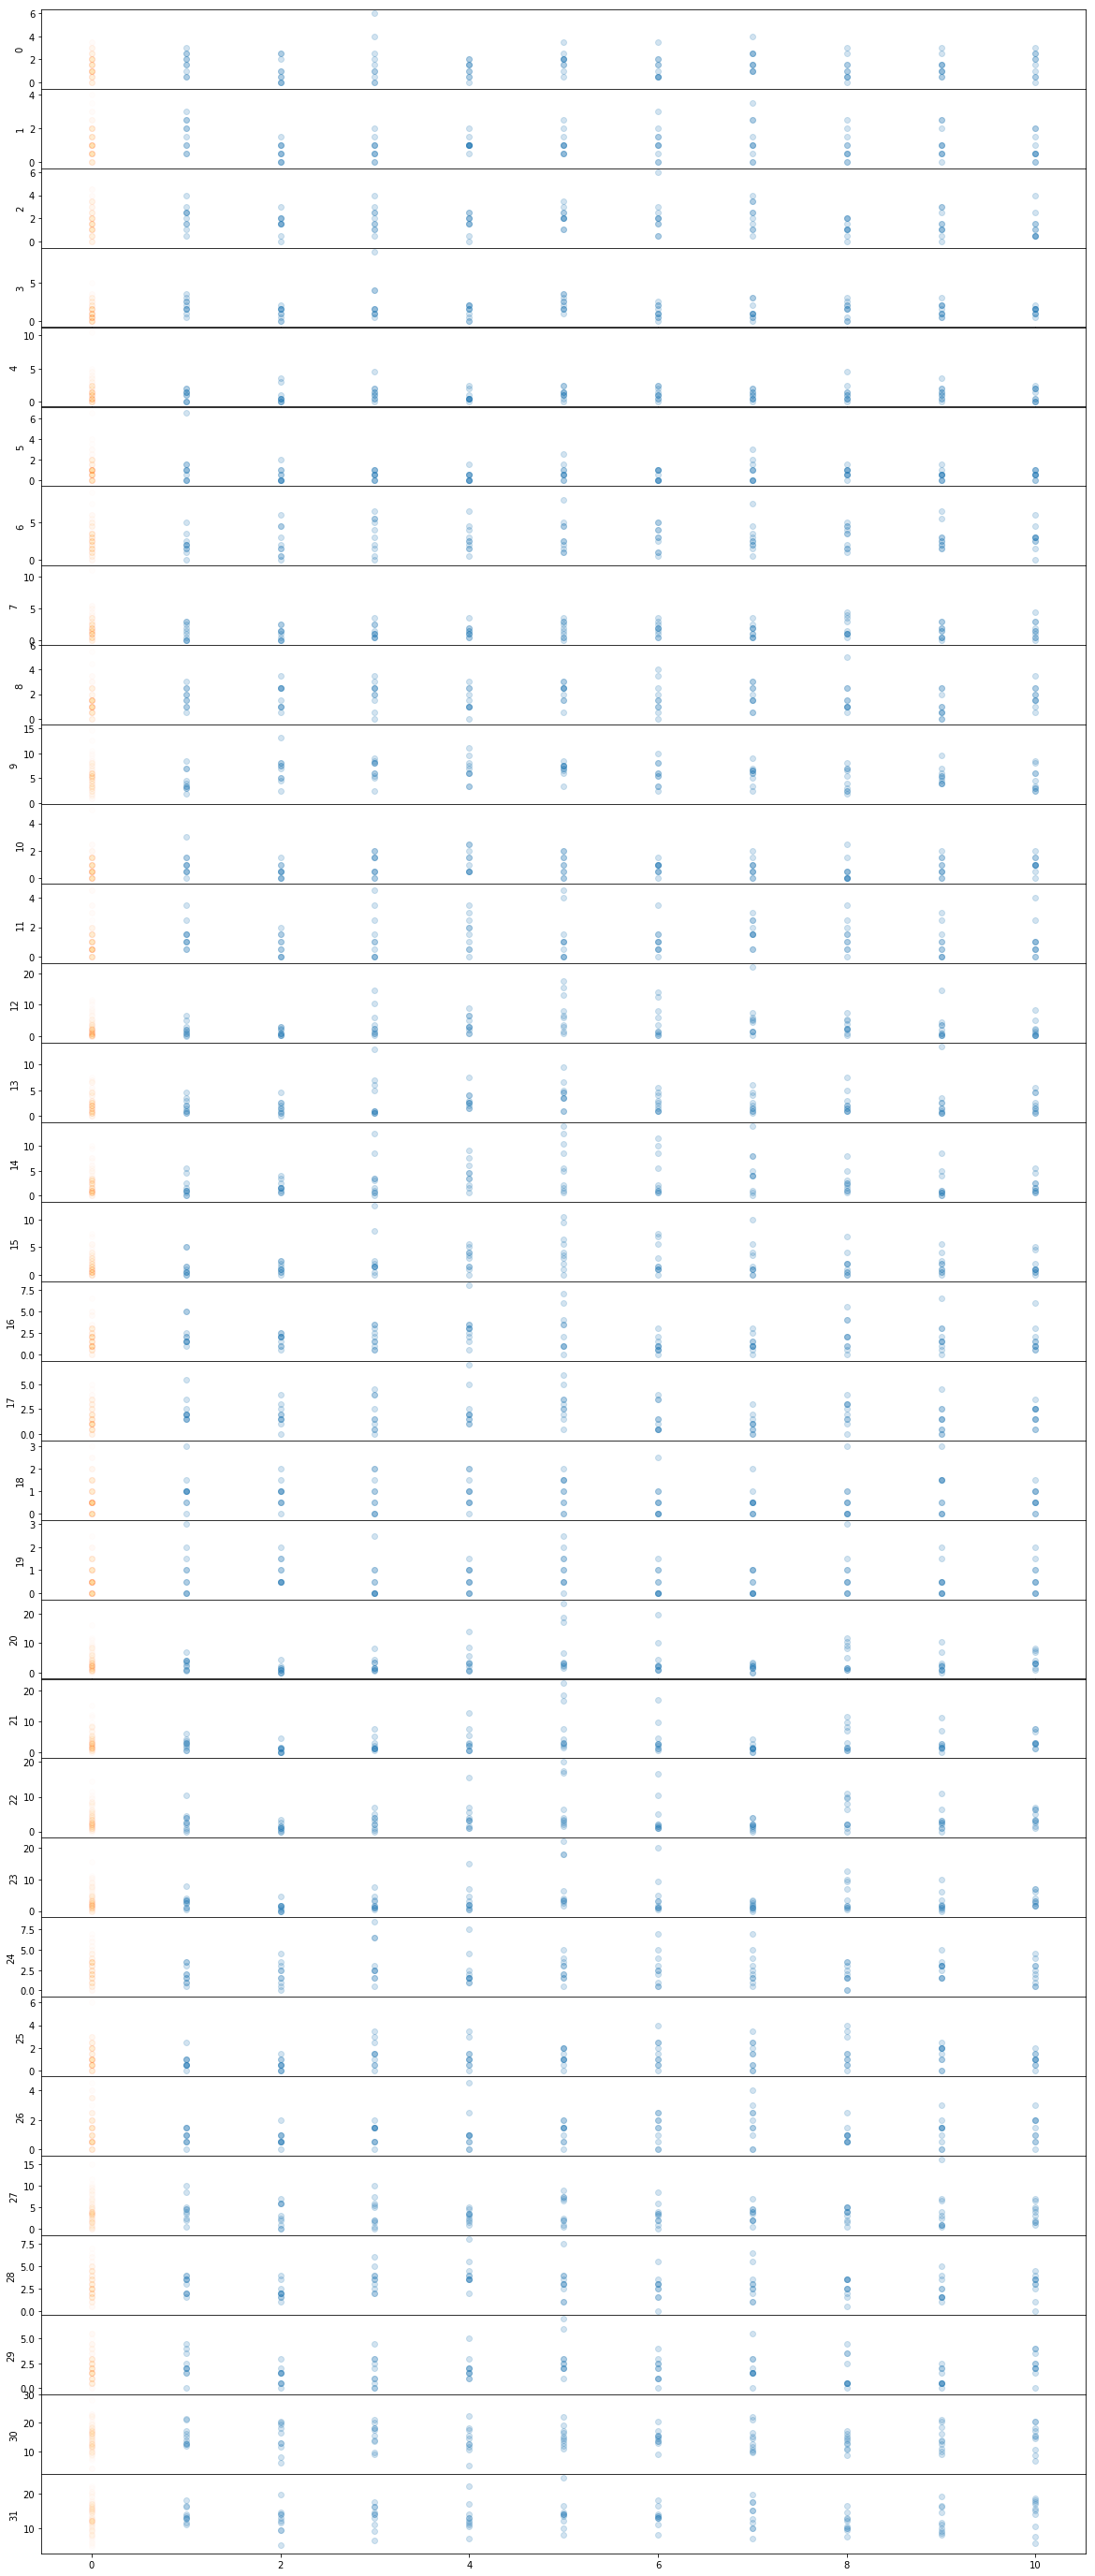

In [32]:
fig, axs = plt.subplots(32, 1, figsize=(20, 50) , facecolor='w', edgecolor='k', sharex=True)
fig.subplots_adjust(hspace = 0.001, wspace=.001)
axs = axs.ravel()

for Channel in range(32):
    axs[Channel].scatter(stimulus_order, FiringRateList[Channel], alpha = 0.2)
    axs[Channel].scatter([0] * len(SilentRateList[Channel]), SilentRateList[Channel], alpha = 0.01, color = 'orange')
    axs[Channel].set_ylabel(Channel)
plt.savefig(OEpath + Experiment + '_preProcessed_cutoff_'+ str(SD_cutoff) + '.pdf', transparent=True, bbox_inches='tight')
plt.show()


In [ ]:
rep(0,1)

In [ ]:
(0, 1)